Loaded chess_board.png (759px x 763px)


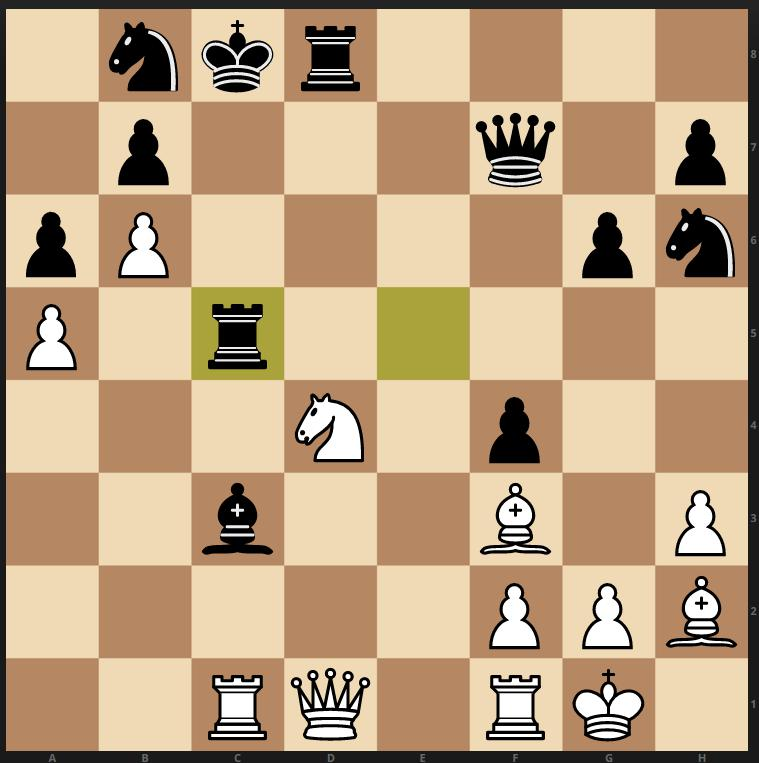

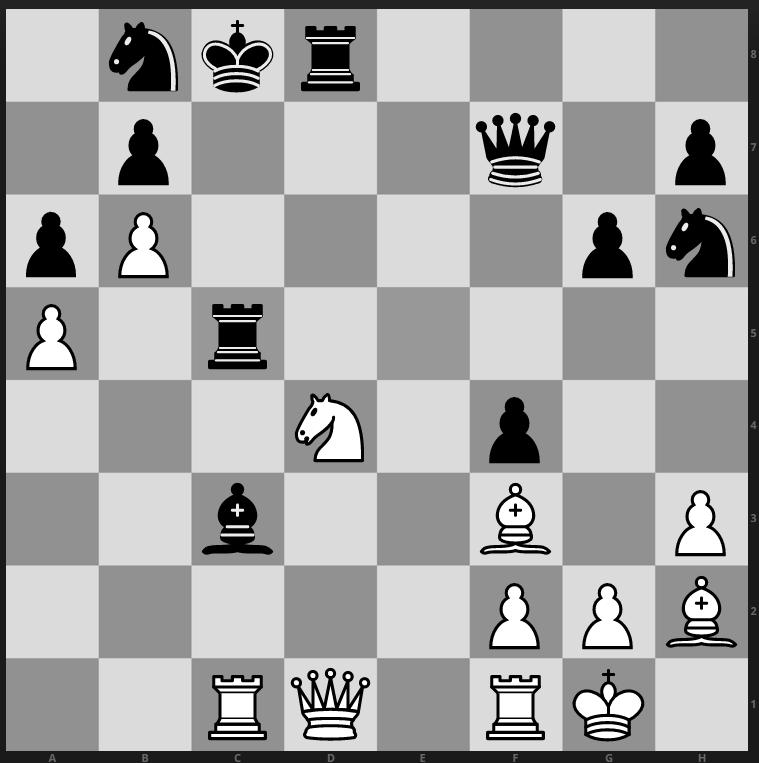

In [1]:
# To filter unwanted TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np

# Whether or not suppress printing of small floating point values using scientific notation
np.set_printoptions(suppress = True)

# Enter an interactive TensorFlow Session.
sess = tf.InteractiveSession()

# Import for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display


# Display an array as a picture
def display_array(a, format = 'jpeg', rng = [0, 1]):
    a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    file = BytesIO()
    PIL.Image.fromarray(a).save(file, format)
    display(Image(data = file.getvalue()))


img_file = 'chess_board.png'
folder = "."
img = PIL.Image.open("%s/%s" % (folder,img_file))

print ("Loaded %s (%dpx x %dpx)" % (img_file, img.size[0], img.size[1]))

# Resize if image larger than 2000 pixels on a side
if img.size[0] > 2000 or img.size[1] > 2000:
    print ("Image too big (%d x %d)" % (img.size[0], img.size[1]))
    new_size = 500.0  # px
    if img.size[0] > img.size[1]:
        # resize by width to new limit
        ratio = new_size / img.size[0]
    else:
        # resize by height
        ratio = new_size / img.size[1]
    print ("Reducing by factor of %.2g" % (1. / ratio))
    img = img.resize(img.size * ratio, PIL.Image.ADAPTIVE)
    print ("New size: (%d x %d)" % (img.size[0], img.size[1]))

# See original image
display_array(np.asarray(img), rng = [0, 255])

# Convert to grayscale and array
grayscale_image_array = np.asarray(img.convert("L"), dtype = np.float32) # translates a color image to black and white (mode “L”)

# Display grayscale image
display_array(grayscale_image_array, rng=[0,255])
